1. Setup Environment

In [5]:
# Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
%matplotlib inline

# Helper: apply consistent time‑axis styling
def style_time_axis(ax, start=None, end=None):
    if start or end:
        ax.set_xlim(start, end)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

2. Data Retrieval & Preparation

In [7]:
#  Retrieve and structure IBGE SIDRA data
url = "https://apisidra.ibge.gov.br/values/t/7524/n1/all/v/29,1988/p/all/c12716/115236/c1835/72206"
raw = requests.get(url).json()
df_raw = pd.DataFrame(raw[1:], columns=raw[0])

# Rename and convert to numeric
df = (
    df_raw.rename(columns={'D3N':'PeriodText','D2C':'VarCode','V':'Value'})
)
df['Value'] = pd.to_numeric(
    df['Value'].str.replace(',', '.', regex=False), errors='coerce'
)

# Parse quarter & year → datetime index
df[['Q','Y']] = df['PeriodText'].str.extract("(\d)º trimestre (\d{4})")
quarter_map = {'1':'01','2':'04','3':'07','4':'10'}
df['Period'] = pd.to_datetime(df['Y'] + '-' + df['Q'].map(quarter_map) + '-01')

# Clean and pivot to wide format
df['VarCode'] = df['VarCode'].astype(int)
df = df.drop(columns=['PeriodText','Q','Y'])
df_pivot = (
    df.pivot(index='Period', columns='VarCode', values='Value')
      .rename(columns={29:'BreederHerd', 1988:'EggsSet'})
      .sort_index()
)

# Final check
# df_pivot.head()  # Uncomment to preview

3. Metric Computation

In [26]:
# Derive productivity and growth indicators
breeders     = df_pivot['BreederHerd']
eggs         = df_pivot['EggsSet']

# Quarterly yield (eggs per breeder)
yield_q      = eggs / breeders

# 12-month moving averages ≃ 4-quarter rolling window
breeders_ma12 = breeders.rolling(window=4).mean()
yield_ma12    = yield_q.rolling(window=4).mean()

# Year-over-year egg production growth
eggs_annual  = eggs.resample('YE').sum()
eggs_yoy     = eggs_annual.pct_change() * 100
eggs_yoy.index = eggs_yoy.index.year

4. Publication Quality Visualization

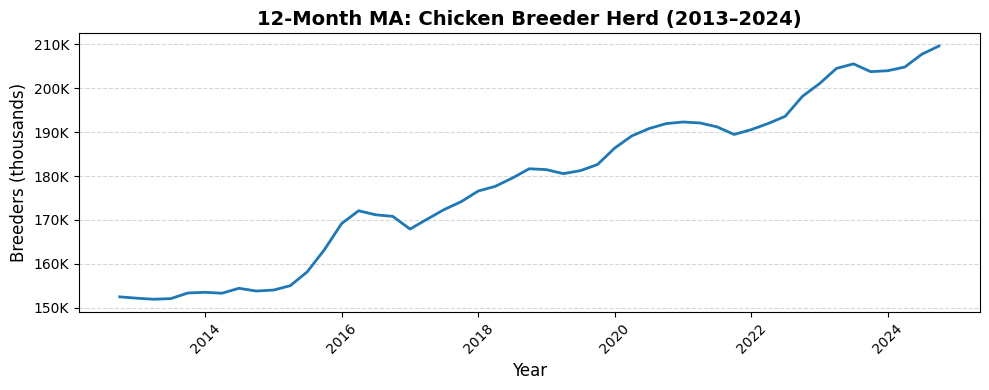

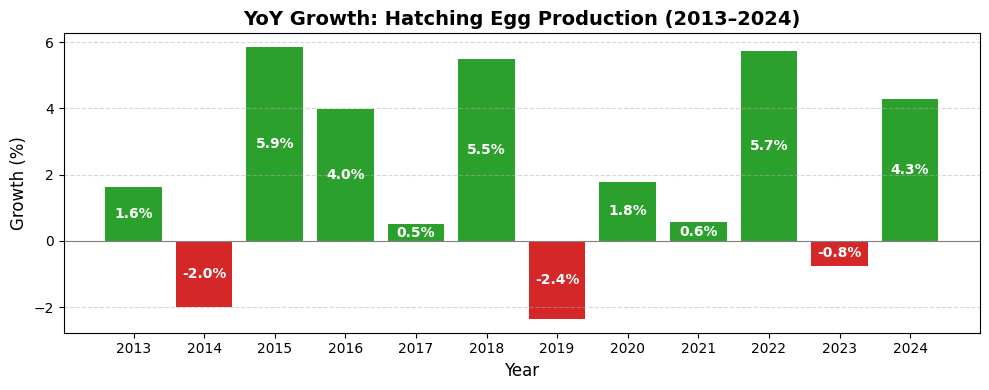

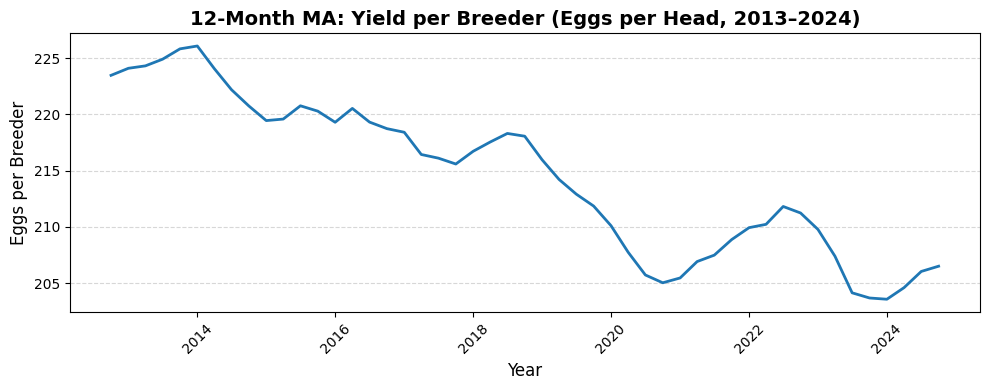

In [27]:
# 4.1 Chicken Breeder Herd: 12-Month MA
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(breeders_ma12.index, breeders_ma12.values, linewidth=2)
ax.set_title('12-Month MA: Chicken Breeder Herd (2013–2024)', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Breeders (thousands)', fontsize=12)
# X-axis ticks every 2 years
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
# Y-axis formatter: thousands with K suffix
def thousands(x, pos): return f"{int(x/1000)}K"
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('breeder_herd_professional.png')

# 4.2 Hatching Egg Production: YoY Growth
fig, ax = plt.subplots(figsize=(10, 4))
y = eggs_yoy.loc[2013:2024]
colors = ['#2ca02c' if v >= 0 else '#d62728' for v in y.values]
bars = ax.bar(y.index.astype(str), y.values, color=colors)
ax.set_title('YoY Growth: Hatching Egg Production (2013–2024)', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Growth (%)', fontsize=12)
ax.axhline(0, color='gray', linewidth=0.8)
ax.grid(axis='y', linestyle='--', alpha=0.5)
# Annotate percentages inside bars
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, h/2,
        f"{h:.1f}%", ha='center', va='center', color='white', weight='bold'
    )
plt.tight_layout()
plt.savefig('eggs_yoy_professional.png')

# 4.3 Yield per Breeder: 12-Month MA
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(yield_ma12.index, yield_ma12.values, linewidth=2)
ax.set_title('12-Month MA: Yield per Breeder (Eggs per Head, 2013–2024)', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Eggs per Breeder', fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('yield_per_breeder_professional.png')

5. Export Cleaned Data

In [28]:
# Save cleaned dataset for downstream models
df_pivot.to_csv('cleaned_poultry_data.csv')